# plot_lines_tStudent

A partir das tabelas de correlação de anomalia do SCANTEC, é possível calcular a Transformada de Fisher e utilizar os valores da transformada para o cálculo do teste de significância. Este cálculo baseia-se no documento "Significance Testing for Forecast Skills[^2]". A função `plot_lines_tStudent` é utilizada para este propósito. Porém, diferentemente da função `plot_lines`, para usar a função `plot_lines_tStudent`, é necessário executar o SCANTEC para o período desejado e também para os intervalos dentro do período desejado. Dessa forma, se a intenção do usuário é avaliar o modelo para o período entre 2020060100 e 2020083100, será necessário também realizar a avaliação para os intervalos de tempo entre estas duas datas, ie., com frequência a cada 6, 12 ou 24 horas. Neste tipo de avaliação, no namelist `scantec.conf` as variáveis `Starting Time` e `Ending Time` são sempre iguais e elas podem ser atualizadas com o auxílio de algum script que se encarregue de calcular as novas datas.

---
[^2]: Disponível em [https://gmao.gsfc.nasa.gov/research/atmosphericassim/AVHRR/skilldiff_desc.pdf](https://gmao.gsfc.nasa.gov/research/atmosphericassim/AVHRR/skilldiff_desc.pdf)

Para acessar a documentação da função `plot_lines_tStudent`, basta utilizar o comando a seguir:

In [31]:
help(scanplot.plot_lines_tStudent)

Help on function plot_lines_tStudent in module plot_functions:

plot_lines_tStudent(dataInicial, dataFinal, dTable_series, Exps, Var, VarName, ldrom_exp, ldrosup_exp, ldroinf_exp, varlev_exps, outDir, **kwargs)
    plot_lines_tStudent
    
    Esta função plota gráficos de linha acompanhados dos resultados do teste de significância t-Student.
    Os gráficos são plotados apenas com base nas tabelas de correlação de anomalia do SCANTEC.
    
    Parâmetros de entrada
    ---------------------
        Exps        : lista com os nomes dos experimentos;
        ldrom_exp   : curva do teste referente ao experimento;
        ldrosup_exp : limite superior do teste;
        ldroinf_exp : limite inferior do teste;
        varlev_exps : dataframes com as variáveis dos experimentos.
    
    Parâmetros de entrada opcionais
    -------------------------------
        showFig : valor Booleano para mostrar ou não as figuras durante a plotagem:
                  * showFig=False (valor padrão), não mo

Através da documentação da função, o usuário deve observar que é necessário utilizar as seguintes funções:

* `concat_tables_and_loc`
* `df_fill_nan`
* `calc_tStudent`

Estas funções são auxiliares à função `plot_lines_tStudent` e, nesta versão do SCANPLOT, elas devem ser aplicadas manualmente.

Para obter a documentação das funções, basta utilizar o comando `print(funcao.__doc__)` ou `help(funcao)`.

Embora o nome da função `plot_lines_tStudent` seja semelhante ao nome da função `plot_lines`, o seu uso e requerimentos são diferentes. A função `plot_lines_tStudent` foi preparada para plotar os gráficos de correlação de anomalia para uma lista de experimentos. Os valores de correlação de anomalia são utilizados para o cálculo do teste de significância t-Student, que permite verificar a significância estatísticas dos resultados apresentados pelas curvas, quanto à sua diferença.

Antes de executar a função `get_dataframe`, a lista `Exps` será redefinida para que todos os experimentos  disponíveis possam ser avaliados:

In [32]:
Exps = list(data_conf['Experiments'].keys())

Para a utilização da função `plot_lines_tStudent`, é necessário carregar as tabelas de correlação de anomalia calculadas pelo SCANTEC para os intervalos dentro do período de avaliação. Para isso, a função `get_dataframe` deve ser utilizada com a opção `series=True`:

In [33]:
dTable_series = scanplot.get_dataframe(dataInicial,dataFinal,Stats,Exps,outDir,series=True)

In [34]:
dTable_series

{'ACORX126_20200601002020060100T.scan':     %Previsao  psnm:000  temp:850  temp:500  temp:250  umes:925  umes:850  \
 0           0     0.999     0.998     1.000     0.999     0.289     0.141   
 1          24     0.979     0.985     0.997     0.991     0.123     0.070   
 2          48     0.972     0.979     0.994     0.981     0.241     0.188   
 3          72     0.952     0.970     0.987     0.969     0.233     0.084   
 4          96     0.938     0.961     0.982     0.962     0.234     0.137   
 5         120     0.922     0.956     0.980     0.951     0.214     0.141   
 6         144     0.895     0.947     0.974     0.941     0.096     0.142   
 7         168     0.852     0.939     0.968     0.933     0.197     0.157   
 8         192     0.840     0.936     0.964     0.921     0.134     0.090   
 9         216     0.828     0.927     0.958     0.912     0.209     0.082   
 10        240     0.749     0.918     0.950     0.903     0.220     0.086   
 11        264     0.682 

As tabelas de avaliação do período geradas pelo SCANTEC, já foram previamente carregadas através do comando `dTable = get_dataframe(dataInicial,dataFinal,Stats,Exps,outDir,series=False)`.

Com o auxílio da função `concat_tables_and_loc`, serão criadas as listas concatenadas com todos os dataframes dos experimentos contendos os valores de correlação de anomalia necessários. Na versão atual do SCANPLOT, apenas uma variável deverá ser avaliada. Para isso, a variável `Var` precisará ser definida da seguinte forma:

In [35]:
Var = Vars[0][0].lower()

In [36]:
VarName = Vars[0][1]

In [37]:
varlev_exps = scanplot.concat_tables_and_loc(dTable,dataInicial,dataFinal,Exps,Var,series=False)

In [38]:
varlev_dia_exps = scanplot.concat_tables_and_loc(dTable_series,dataInicial,dataFinal,Exps,Var,series=True)

Dependendo dos experimentos avaliados, faz-se necessário normalizar o tamanho dos dataframes. No exemplo, os experimentos `GFS` e `X666`, possuem tamanhos diferentes quanto ao horizonte de previsões. No experimento `GFS`, são considerados 11 dias de previsões enquanto que no experimento `X666`, são considerados 13 dias. Nos demais experimentos (`T126`, `TENM`, `X126` e `XENM`), são considerados 15 dias de previsões.

Para normalizar o tamanho dos dataframes contidos nas listas `varlev_exps` e `varlev_dia_exps`, utiliza-se a função `df_fill_nan` do SCANPLOT, cujos resultados serão armazenados na lista `lst_varlev_dia_exps_rsp`.

In [39]:
lst_varlev_dia_exps_rsp = scanplot.df_fill_nan(varlev_exps,varlev_dia_exps)

Com as tabelas concatenadas e em lista, o próximo passo é realizar o cálculo das estatísticas do teste de significância t-Student. Para isso, internamente, o SCANPLOT utiliza os módulos `t` e `ttest_ind` do pacote `scipy.stats`. A função `calc_tStudent` do SCANTEC se encarrega dos procedimentos necessários para esta tarefa. Esta função, calcula os resultados do teste de significância a partir da Transformada de Fisher. Os resultados da aplicação da função, são os seguintes:

* `ldrom_exp`: uma lista com o valor médio do teste de significância (calculados a partir da média e da variância da transformada de Fisher) para cada experimento;
* `ldrosup_exp`: uma lista com os valores críticos superiores para cada experimento;
* `ldroinf_exp`: uma lista com os valores críticos inferiores para cada experimento;

In [40]:
ldrom_exp, ldrosup_exp, ldroinf_exp = scanplot.calc_tStudent(lst_varlev_dia_exps_rsp)

Finalmente, com as estatísticas do teste de significância calculados, pode-se aplicar a função `plot_lines_tStudent` para plotar os gráficos de correlação de anomalia com o teste de significância:

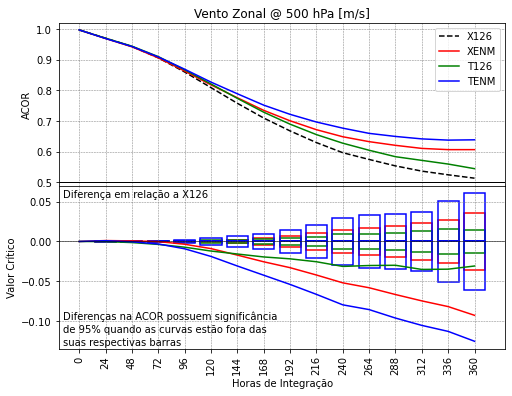

In [41]:
scanplot.plot_lines_tStudent(dataInicial,dataFinal,dTable_series,Exps,Var,VarName,ldrom_exp,ldrosup_exp,ldroinf_exp,varlev_exps,outDir,figDir=figDir,saveFig=True,showFig=True)

Na verificação acima, o teste de significância mostra que, em relação à referência `X126` (curva tracejada em preto), as diferenças entre as curvas (gráfico de cima, correlação de anomalia - `ACOR`) são significativas quando as respectivas curvas de baixo estão fora (positivo ou negativo) das barras que representam os valores críticos. Isso significa que as diferenças entre as correlações de anomalia, quando fora das barras, são significativas com 95% de confiança.

Assim como a função `plot_lines`, a função `plot_lines_tStudent` também aceita parâmetros para a customização das cores das curvas:

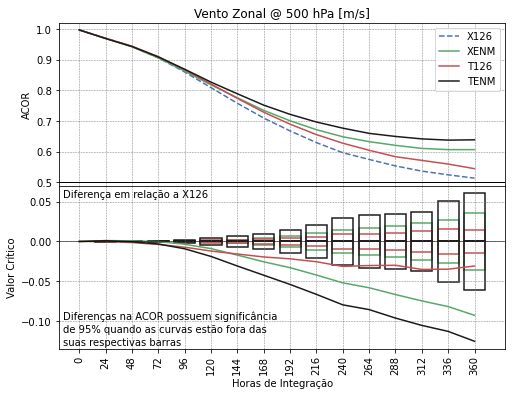

In [42]:
lineStyles = ['b', 'g', 'r', 'k']
scanplot.plot_lines_tStudent(dataInicial,dataFinal,dTable_series,Exps,Var,VarName,ldrom_exp,ldrosup_exp,ldroinf_exp,varlev_exps,outDir,figDir=figDir,lineStyles=lineStyles,saveFig=True,showFig=True)